# Imports

In [1]:
import Thymio as th
import time
import numpy as np
import matplotlib.pyplot as plt

## Test pour avancer tout droit

In [2]:
### Setting up the origin and the kalman filter
current_pos = np.array([0,0,0])
current_speed = np.array([0,0,0])
z_predicted = np.concatenate([current_pos,current_speed]) #kalman_state
sigma_predicted = np.diag([0,0,0,0,0,0])

### Position goal
goal_pos = np.array([100,0])

print("Open thymio")
thymio = th.Thymio()
await thymio.initiateLock()
print("Thymio opened")

Open thymio
Thymio opened


### Autre solution

In [3]:
### Data storage for plotting
xdata, ydata, thetadata, Vleftdata, Vrightdata = [], [], [], [], []
iteration_times = []

while True:
    start_time = time.time()  # Capture start time

    if thymio.robot_close_waypoint(current_pos[:2], goal_pos[0], goal_pos[1]):
        print("Goal reached")
        thymio.set_var("motor.left.target", 0)
        thymio.set_var("motor.right.target", 0)
        break

    Vleft = thymio.getSpeedL()
    Vright = thymio.getSpeedR()

    thymio.navigate(current_pos, goal_pos)
    current_pos = z_predicted[:3] # Is used for the controller

    xdata.append(current_pos[0])
    ydata.append(current_pos[1])
    thetadata.append(current_pos[2])
    Vleftdata.append(Vleft)
    Vrightdata.append(Vright)

    z_filtered, sigma_filtered= thymio.filtering_step(z_k_k_1 = z_predicted, 
                                    sigma_k_k_1 = sigma_predicted, 
                                    V_left_measure = Vleft, 
                                    V_right_measure = Vright, 
                                    camera_working=False)
    
    z_predicted, sigma_predicted = thymio.prediction_step(z_filtered, sigma_filtered)

    obstacle,detected = thymio.getObstaclePosition()
    if detected:
        print("Obstacle detected")
        
    

    end_time = time.time()  # Capture end time
    iteration_time = end_time - start_time  # Compute iteration time
    iteration_times.append(iteration_time)  # Store iteration time
    print(f"Iteration time: {iteration_time:.6f} seconds")  # Print iteration time


Is the goal reached ?
False
Iteration time: 1.218158 seconds
Is the goal reached ?
False
Iteration time: 1.114905 seconds
Is the goal reached ?
False
Iteration time: 1.113595 seconds
Is the goal reached ?
False
Iteration time: 1.115319 seconds
Is the goal reached ?
True
Goal reached


In [4]:
thymio.set_var("motor.left.target", 0)
thymio.set_var("motor.right.target", 0)

In [4]:
print(f'Première estimation Ts = {np.mean(np.array(iteration_times))}')

Première estimation Ts = 1.140494167804718


##### Affichage position

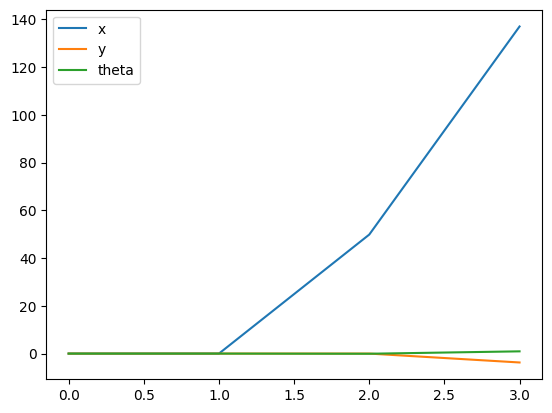

In [5]:
plt.plot(xdata, label='x')
plt.plot(ydata, label='y')
plt.plot(thetadata, label='theta')
plt.legend()

In [6]:
xdata

[0, 0.0, 49.858695652173914, 137.05433359231336]

##### Vérification du fait que le robot atteigne bien sa cible

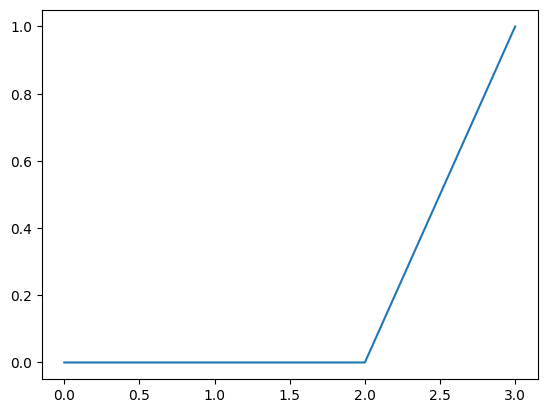

In [7]:
ones = np.array([1, 1, 1, 1])
F = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
goal_pos = np.array([100,0])
l=50

reached=[]
for i in range(len(xdata)):
    current_pos=np.array([xdata[i],ydata[i]])
    if all(F @ (current_pos - goal_pos) <= l * ones):
        reached.append(True)
    else:
        reached.append(False)

plt.plot(reached)

##### Calcul vitesse

In [8]:
Vleftdata = np.array(Vleftdata)
Vrightdata = np.array(Vrightdata)

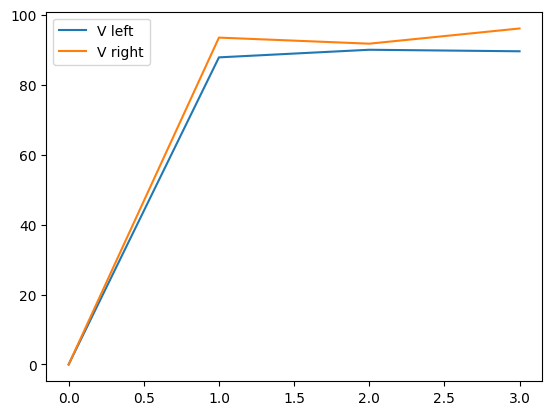

In [9]:
plt.plot(Vleftdata, label="V left")
plt.plot(Vrightdata, label="V right")
plt.legend()

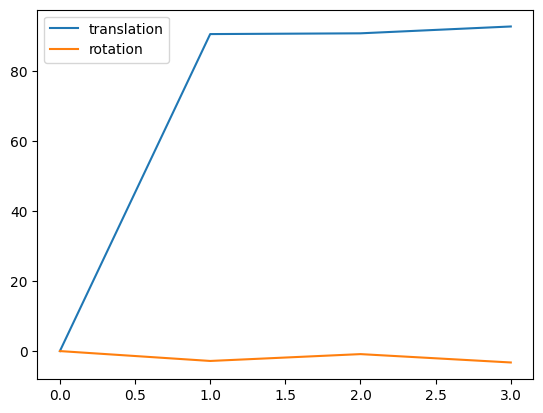

In [10]:
plt.plot((Vleftdata+Vrightdata)/2, label = "translation")
plt.plot((Vleftdata-Vrightdata)/2, label = "rotation")
plt.legend()

[ 0.          0.         -0.06646575  0.93743374]
[ 0.         -0.06045106 -0.01860033 -0.06975122]
[0.0, -0.04292025110439437, -0.013206231109044413, -0.04952336665891652]


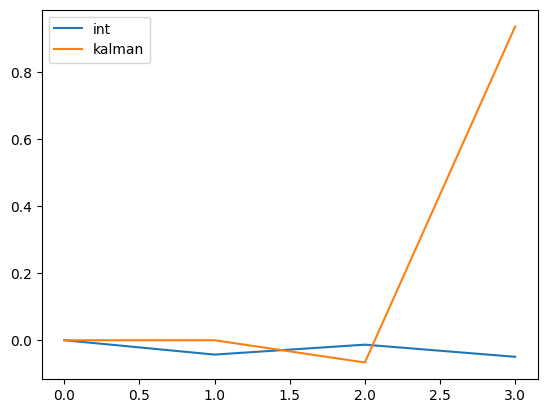

In [11]:
L = 46.75
theta_dot = (Vleftdata-Vrightdata)/2/L

print(np.array(thetadata))
print(theta_dot)

Ts = 0.71
theta_int=[0]

theta_int=[theta_int[-1] + Ts*theta_dot[i] for i in range(len(theta_dot))]

print(theta_int)

plt.plot(theta_int, label='int')
plt.plot(thetadata, label='kalman')
plt.legend()

[0, 0.0, 64.36304347826086, 128.8804347826087]


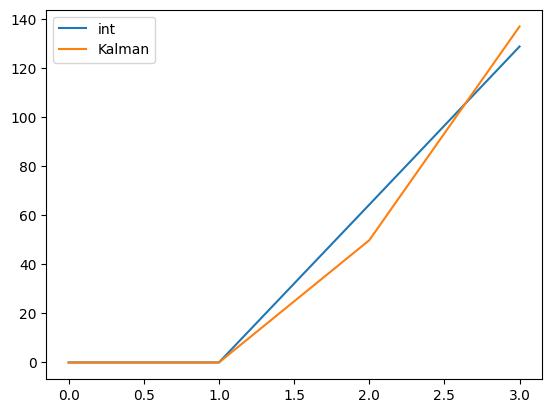

In [12]:
V = (Vrightdata + Vleftdata)/2
Distance = [0]

for i in range(len(V)-1):
    Distance.append(Distance[-1] + Ts*V[i])

print(Distance)
plt.plot(Distance, label="int")
plt.plot(xdata, label="Kalman")
plt.legend()

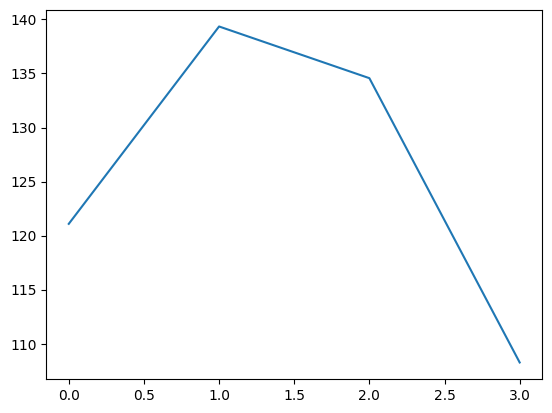

In [19]:
plt.plot(V)

In [22]:
x_traveled = 285 # mm

Ts_2=x_traveled/np.sum(V[:-1])

print(f'Deuxième estimation de Ts = {Ts_2}')

Deuxième estimation de Ts = 0.7215189873417721


[0, 87.3665382498624, 187.90864061640065, 285.0]


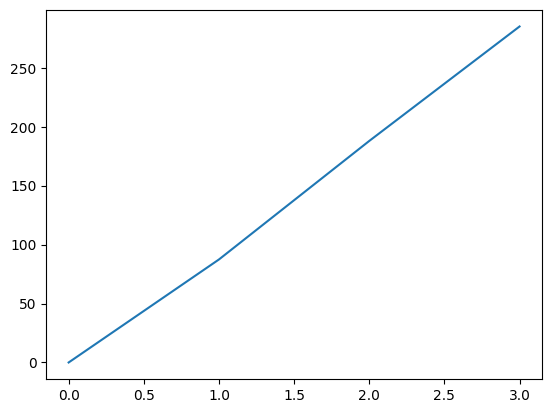

In [23]:
Distance_2 = [0]

for i in range(len(V)-1):
    Distance_2.append(Distance_2[-1] + Ts_2*V[i])

print(Distance_2)
plt.plot(Distance_2)

[  0.         119.56521739 137.82608696 135.2173913 ]
[  0.         122.60869565 140.86956522 133.91304348]
[  0.         121.08695652 139.34782609 134.56521739]
[0, 0.0, 132.50834724540903, 285.0]
[0, 0.0, 49.46847826086957, 135.04385176710394]
4
4


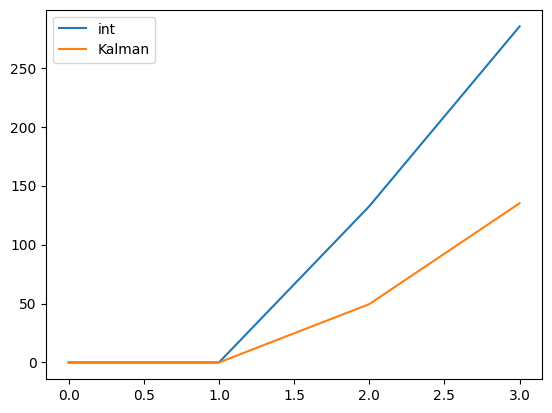

In [49]:
Vleftdata_2 = np.zeros(4)
Vrightdata_2 = np.zeros(4)

Vleftdata_2[1:] = Vleftdata[:-1]
Vrightdata_2[1:] = Vrightdata[:-1]

print(Vleftdata_2)
print(Vrightdata_2)

V_2 = (Vleftdata_2 + Vrightdata_2)/2

print(V_2)

Distance_3 = [0]

for i in range(len(V_2)-1):
    Distance_3.append(Distance_3[-1] + Ts_3*V_2[i])

print(Distance_3)
print(xdata)
print(len(Distance_3))
print(len(xdata))
plt.plot(Distance_3, label="int")
plt.plot(xdata, label ="Kalman")
plt.legend()

In [48]:
Ts_3 = x_traveled/np.sum(V_2[:-1])
print(Ts_3)

1.0943238731218699


#### Trying to rebuild the kalman filter

In [33]:
print(xdata)
print(ydata)
print(thetadata)
print(Vleftdata)
print(Vrightdata)

[0, 0.0, 49.46847826086957, 135.04385176710394]
[0, 0.0, 0.0, -1.251344651013118]
[0, 0.0, -0.023100334926148457, 0.8055473224958153]
[119.56521739 137.82608696 135.2173913  136.95652174]
[122.60869565 140.86956522 133.91304348  79.56521739]


In [35]:
z_0 = np.zeros(6)
L = 46.75  # mm - demi-distance entre les 2 roues
Ts = 0.71
W = np.diag([0.001, 0.001, 0.00001, 0.001, 0.001, 0.00001])
V_nc = np.diag([0.001, 0.00001])
A = np.array(
    [
        [1, 0, 0, Ts, 0, 0],
        [0, 1, 0, 0, Ts, 0],
        [0, 0, 1, 0, 0, Ts],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
    ]
)

In [36]:
def g_nc(z):
    theta = z[2]
    s_nc = [
        z[3] * np.cos(theta)
        + z[4] * np.sin(theta),  # x_dot*cos(theta) + y_dot*sin(theta)
        L * z[5],
    ]  # L*theta_dot
    return np.array(s_nc)


def grad_g_nc(z):
    theta = z[2]
    x_dot, y_dot = z[3], z[4]
    grad = [
        [
            0,
            0,
            -x_dot * np.sin(theta) + y_dot * np.cos(theta),
            np.cos(theta),
            np.sin(theta),
            0,
        ],
        [0, 0, 0, 0, 0, L],
    ]
    return np.array(grad)

def constructing_s(V_left_measure,V_right_measure):
    s_nc = np.array(
        [(V_left_measure + V_right_measure) / 2,
        (V_left_measure - V_right_measure) / 2])
    return s_nc


def filtering_step(
        z_k_k_1,
        sigma_k_k_1,
        V_left_measure,
        V_right_measure,
    ):
        ### Computing the variables that are dependant on the state of the camera
        C_k = grad_g_nc(z_k_k_1)
        V = V_nc
        s_k = constructing_s(V_left_measure,V_right_measure)
        g_k = g_nc(z_k_k_1)

        ### The real filtering step that can be rewritten without any problem
        L_k_k = sigma_k_k_1 @ C_k.T @ np.linalg.inv(C_k @ sigma_k_k_1 @ C_k.T + V)
        sigma_k_k = sigma_k_k_1 - L_k_k @ C_k @ sigma_k_k_1
        z_k_k = z_k_k_1 + L_k_k @ (s_k - g_k)

        return z_k_k, sigma_k_k

def prediction_step(z_k_k, sigma_k_k):
    z_k_1_k = A @ z_k_k
    sigma_k_1_k = A @ sigma_k_k @ A.T + W
    return z_k_1_k, sigma_k_1_k

